GAN OVERVIEW AND NOTES

- trains a discriminator and generator
- turns unsupervised to supervised
- generator tries to fool discriminator (like a fight between both models)
- both trained at the same time
- no labels required in dataset


Modes of failure:
- mode collapse
- too little data
- Not enough training time
- generator biases towards one type of output and repeatedly outputs similar outputs as it seems to fool the discriminator the best

Points to take note:
- long training times (provide weights?)
- losses should not askew, but remain around a constant. The losses usually eventually converge after one loss spikes
- an extremely low loss likely means mode collapse
- dataset needs even distribution between classes


1. discrimnator accuracy (metrics)

In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import os

from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import Callback

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
# hyperparameters

bsize = 128
lsd = 128

glr = 1e-4
dlr = 1e-5

In [4]:
# pipeline
ds = tfds.load('fashion_mnist', split='train')
dsiterate = ds.as_numpy_iterator()

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling ~\tensorflow_datasets\fashion_mnist\3.0.1.incomplete5279V7\fashion_mnist-train.tfrecord*...:   0%|  …

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling ~\tensorflow_datasets\fashion_mnist\3.0.1.incomplete5279V7\fashion_mnist-test.tfrecord*...:   0%|   …

Dataset fashion_mnist downloaded and prepared to ~\tensorflow_datasets\fashion_mnist\3.0.1. Subsequent calls will reuse this data.


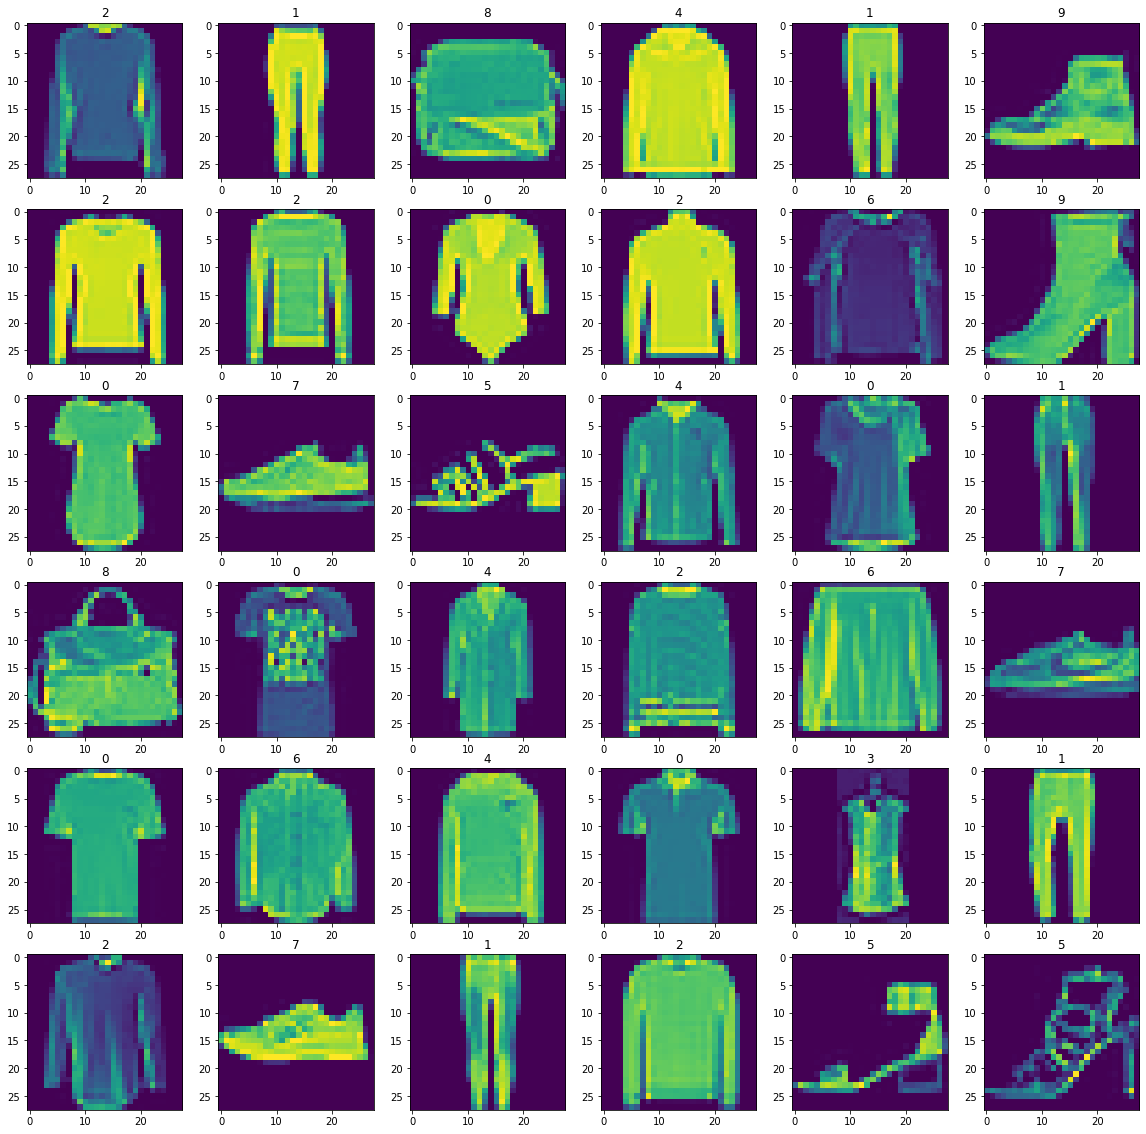

In [5]:
fig, ax = plt.subplots(ncols=6, nrows=6, figsize=(20, 20))
for idx, axi in enumerate(ax.flat):
    batch = dsiterate.next()
    axi.imshow(np.squeeze(batch['image']))
    axi.title.set_text(batch['label'])

In [20]:
class preprocess:
    
    @staticmethod
    def scale_img(data):
        return data['image'] / 255

class ML:
    @staticmethod
    def build_gen():
        xin = Input(lsd)
        x = Dense(7*7*128, activation='swish')(xin)
        x = Reshape((7, 7, 128))(x)

        x = UpSampling2D()(x)
        x = Conv2D(128, 5, padding='same', activation='swish')(x)

        x = UpSampling2D()(x)
        x = Conv2D(128, 5, padding='same', activation='swish')(x)

        x = Conv2D(128, 4, padding='same', activation='swish')(x)
        x = Conv2D(128, 4, padding='same', activation='swish')(x)

        xout = Conv2D(1, 4, padding='same', activation='sigmoid')(x)   # sigmoid so that generated image is also scaled between 0 and 1


        return Model(xin, xout)

    @staticmethod
    def build_discrim():
        
        xin = Input((28, 28, 1))

        x = Conv2D(32, 5, activation='swish')(xin)
        x = Dropout(0.4)(x)

        x = Conv2D(64, 5, activation='swish')(x)
        x = Dropout(0.4)(x)

        x = Conv2D(128, 5, activation='swish')(x)
        x = Dropout(0.4)(x)

        x = Conv2D(256, 5, activation='swish')(x)
        x = Dropout(0.4)(x)

        x = Flatten()(x)
        xout = Dense(1, activation='sigmoid')(x)

        return Model(xin, xout)


    @staticmethod
    def gen_display(model, row=4, col=4, lsp=128):
        fig, ax = plt.subplots(ncols=col, nrows=row, figsize=(20, 20))
        batch = model.predict(np.random.randn(row*col, lsp))
        batch *= 255
        fig.suptitle('Generated Images', fontsize=40)

        for idx, axi in enumerate(ax.flat):
            axi.imshow(np.squeeze(batch[idx]))

In [7]:
ds = tfds.load('fashion_mnist', split='train')
ds = ds.map(preprocess.scale_img)
ds = ds.cache()
ds = ds.shuffle(60000) # number of training images
ds = ds.batch(bsize)
ds = ds.prefetch(64)

In [8]:
gen_loss = BinaryCrossentropy()
dis_loss = BinaryCrossentropy()

gen_opt = Adam(learning_rate=glr)
dis_opt = Adam(learning_rate=dlr)

In [9]:
class FnistGAN(Model):
    
    def __init__(self, generator, discriminator, *args, **kwargs):
        super().__init__(*args, **kwargs)

        self.generator = generator
        self.discriminator = discriminator

    def compile(self, gloss, gop, dloss, dop, *args, **kwargs):
        super().compile(*args, **kwargs)

        self.gen_loss = gloss
        self.dis_loss = dloss

        self.gen_opt = gop
        self.dis_opt = dop
    
    # could use graph execution for faster times
    @tf.function
    def train_step(self, batch):
        

        # Discriminator training


        real_imgs = batch
        # generate images
        fake_imgs = self.generator(tf.random.normal((bsize, lsd)), training=False)

        # discriminator
        with tf.GradientTape() as d_tape:
        
            # generate discriminator predictions
            yhat_real = self.discriminator(real_imgs, training=True)
            yhat_fake = self.discriminator(fake_imgs, training=True) 
            yhat_realfake = tf.concat([yhat_real, yhat_fake], axis=0)

            # label creation
            '''
            0 is REAL images
            1 is FAKE images
            '''

            y_realfake = tf.concat([tf.zeros_like(yhat_real), tf.ones_like(yhat_fake)], axis=0)

            # noise
            noise_real = 0.15*tf.random.uniform(tf.shape(yhat_real))
            noise_fake = -0.15*tf.random.uniform(tf.shape(yhat_fake))
            y_realfake += tf.concat([noise_real, noise_fake], axis=0)

            # loss calculation
            total_d_loss = self.dis_loss(y_realfake, yhat_realfake)

        dgrad = d_tape.gradient(total_d_loss, self.discriminator.trainable_variables)
        self.dis_opt.apply_gradients(zip(dgrad, self.discriminator.trainable_variables)) 



        # Generator Training

        # generator
        with tf.GradientTape() as g_tape:
            
            # generate images
            generated_images = self.generator(tf.random.normal((bsize, lsd)), training=True)

            # predicted labels (from discriminator)
            predicted_labels = self.discriminator(generated_images, training=False) # training is False since we dont want the gradient tracing mechanism to calculate gradient of loss w.r.t to variables in the discriminator

            # loss calculation   ***************  interesting step *****************  
            '''
            We want the generator to fool the discriminator, so the generator should generate images that makes the discriminator think is real,
            hence we are training and optimising the generator to generate images that make the discriminator output 0 for fake images.
            '''
            total_g_loss = self.gen_loss(tf.zeros_like(predicted_labels), predicted_labels)
        
        ggrad = g_tape.gradient(total_g_loss, self.generator.trainable_variables)
        self.gen_opt.apply_gradients(zip(ggrad, self.generator.trainable_variables))

        return {'discrim_loss': total_d_loss, 'gen_loss': total_g_loss}


In [10]:
# generator and discriminator creation

generator = ML.build_gen()
discriminator = ML.build_discrim()


In [13]:
# load any pretrained weights
generator.load_weights(r'weights\generator\generator_1')
discriminator.load_weights(r'weights\discriminator\discriminator_1')

In [14]:
# GAN init

FGAN = FnistGAN(generator, discriminator)

# compiling
FGAN.compile(gen_loss, gen_opt, dis_loss, dis_opt)

In [13]:
class ImageMonitor(Callback):
    def __init__(self, path='val_images', num_imgs=4, latent_dim=128):
        self.num_imgs = num_imgs
        self.latent_dim = latent_dim
        self.path = path

    def on_epoch_end(self, epoch, logs=None):
        generated_images = self.model.generator(tf.random.uniform((self.num_imgs, self.latent_dim)))
        generated_images *= 255
        imgs = generated_images.numpy()
        for i in range(self.num_imgs):
            img = array_to_img(imgs[1])
            img.save(os.path.join(self.path, f'generated_img_epoch{epoch}_{i}.png'))
        print(f'\n{self.num_imgs} images saved in monitor_images\n')

callbacks = [
    ImageMonitor('monitored_images', num_imgs=3, latent_dim=lsd)
    ]

In [ ]:
# TRAINING


# many epochs needed
history = FGAN.fit(ds, epochs=2000, callbacks=callbacks)

In [ ]:
ML.gen_display(generator, row=4, col=4)

In [20]:
# SAVING MODELS

# actual models
# generator.save(r'weights\generator\generator_1.h5')
# discriminator.save(r'weights\discriminator\discriminator_1.h5')

# weights only
generator.save_weights(r'weights_fashion\generator\generator_1')
discriminator.save_weights(r'weights_fashion\discriminator\discriminator_1')

In [18]:
generator = tf.keras.models.load_model(r'D:\.EXTRA_SPACE\.ML\.proj\MNIST_GAN\weights\pretrianed\generatormodel.h5')